# Directed functional/effective network inference on Cellular Automata

## Preliminaries ##

_Adapted from the "Self-organisation and Information Theory" course (module 12, see [course branch](https://github.com/jlizier/jidt/tree/course)) using JIDT._

This notebook requires the following python libraries to be installed for your environment:
1. `jpype1` -- it's important that you install jpype1 rather than jpype!
2. and the usual suspects: `numpy`, `scipy`, `sys`, `matplotlib`

## Introduction ##

In this activity we will perform pairwise functional, directed and then effective network inference using MI and TE on data from an [Elementary Cellular Automata](https://en.wikipedia.org/wiki/Elementary_cellular_automaton). We use this as our example because:
1. We know the structure of the underlying network (a ring network with one nearest neighbour either side), and
2. We have a good understanding of the dynamics.

We'll use a simulation of rule 54, which is known to contain emergent structures known as gliders propagating against a spatiotemporally regular background domain pattern. We will use 10000 cells, with 600 time steps for each in the simulation.

Let's first read in the data and plot the time series dynamics for a subset of the data:

Read in CA data with 600 time steps for 10000 cells
Plotting first 100 time steps for our 100 cells


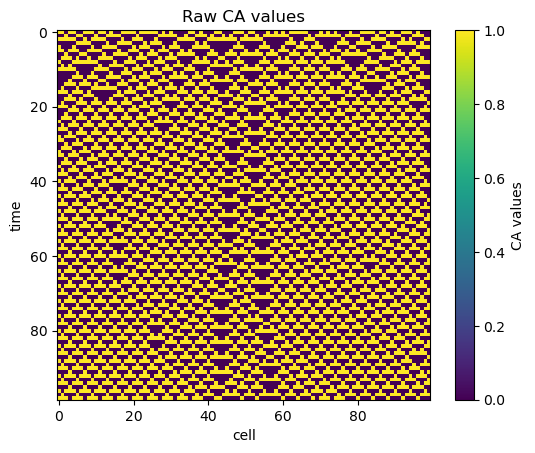

In [1]:
from jpype import * # We'll use this for JIDT
import numpy
import sys
import scipy.io
import matplotlib.pyplot as plt

# Load/prepare the data:
ca54matContents = scipy.io.loadmat('./data/ca54.mat')
# As numpy array:
data = numpy.array(ca54matContents['data']);
print('Read in CA data with %d time steps for %d cells' % (data.shape[0], data.shape[1]))

# We'll only work with a subset of cells:
networkSize=100;

print('Plotting first 100 time steps for our %d cells' % networkSize)
plt.imshow(data[:99,:networkSize]) # Plotting the first 100 time steps for first networkSize cells
plt.xlabel('cell');
plt.ylabel('time');
plt.title('Raw CA values');
cbar = plt.colorbar()
cbar.set_label('CA values');

## A. Functional network inference with Mutual Information

First we will infer the functional network to represent the pairwise statistical relationships between the cells as the nodes in our network. We'll use Mutual Information (MI) for these discrete valued variables, and compute it using the JIDT software.

1. Now open JIDT's MI AutoAnalyser (double click on `infodynamics-1.6.1.jar` in the top level folder, then select `Mutual Informtion` from pop-up box). Then:
   1. Select a Discrete estimator,
   2. Press the `Select` button to browse for a data file: browse to the `data` folder of this distribution, and select `dummyIntData.txt`
   3. Tick the checkbox for `All pairs?`
   4. Untick the checkbox for `Compute result?` (we don't want to run this computation), and
   5. Click `Generate Code`.
3. Select the Python tab, and paste the following code from it into the code cells below:
   1. Ignore all of the import lines, we've done that above.
   2. Paste the section starting with `if (not isJVMStarted()):` into the first code box
   3. Paste everything from `# 1. Construct the calculator:` onwards into the second code box
5. Examine how the generated code is computing the MI for each cell pair.
6. Make a few changes to the code here for our purposes:
    * Once we get to directed network inference, it will make more sense for our outer loop to be over targets, so that we consider the set of sources afterwards for that target. So, swap the order of the loops over `s` and `d` (so that the outer loop is over `d`)
    * We also need to adjust the variables for which we compute the functional network (the code thinks there are only two variables from the dummy data). We're going to work with the first 100 cells (defined above in `networkSize=100;`). So have the loops over `s` and `d` run up to `networkSize` (instead of the default `2` or all the way up to `10000`).
    * Create a 2D array to store the MI values before the for loops, `results = numpy.zeros((networkSize,networkSize));`
    * Remove the `print` statement, and instead assign the result to the results array, as `results[s,d] = result;`

In [2]:
# Paste JVM startup lines here (section starting with `if (not isJVMStarted()):`):

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "./infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)


In [3]:
# Paste analysis code here (everything from `# 1. Construct the calculator:` onwards):

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
calc = calcClass(2, 2, 0)
# 2. No other properties to set for discrete calculators.

results = numpy.zeros((networkSize,networkSize));
# Compute for all pairs:
for d in range(networkSize):
    for s in range(networkSize):
        # For each source-dest pair:
        if (s == d):
            continue
        source = JArray(JInt, 1)(data[:, s].tolist())
        destination = JArray(JInt, 1)(data[:, d].tolist())

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.addObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()

        results[s,d] = result;

6. Run the above code cells, and then run the next code cell to plot the adjacency matrix of the functional network, as well as say the first 100 time steps of the CA dynamics (repeating from above) so we can interpret what's happening:

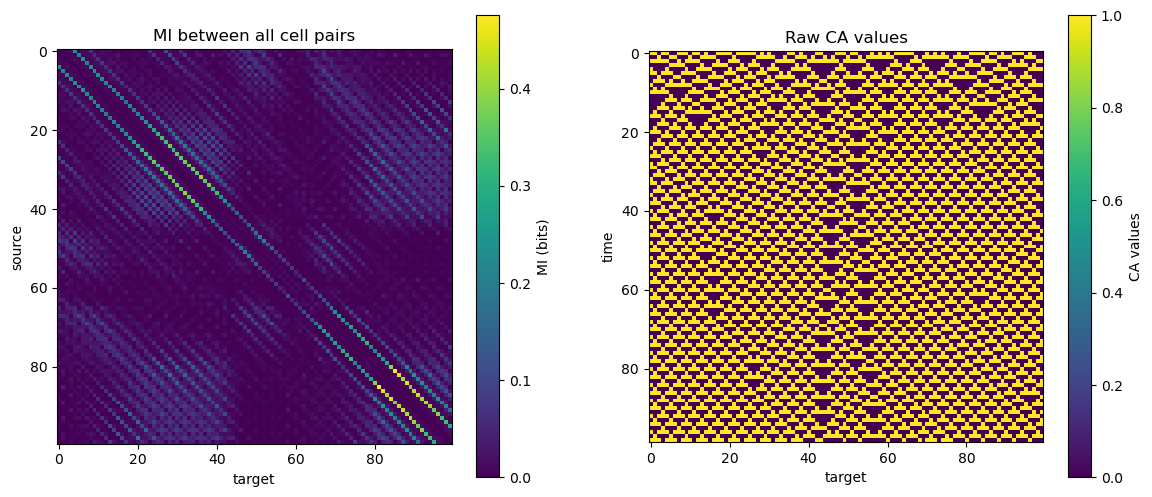

In [4]:
# Plot the functional connectivity
plt.figure(figsize=(14,6))
plt.subplot(1,2,1) # left subplot
plt.imshow(results)
plt.xlabel('target');
plt.ylabel('source');
plt.title('MI between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('MI (bits)');
# Plot the first 100 time steps for the cells we're analysing:
plt.subplot(1,2,2) # right subplot
plt.imshow(data[:99,:networkSize]) # Plotting the first 100 time steps for first networkSize cells
plt.xlabel('target');
plt.ylabel('time');
plt.title('Raw CA values');
cbar = plt.colorbar()
cbar.set_label('CA values');

7. Look at the results for the adjacency matrix for the MI functional network in figure 1 (left):
    * What do you observe in terms of the functional network structure? Which sources have the highest MI to each target?
    * How does it compare to what you know the underlying causal structure to be? Is that what you expected to see?
    * Can you interpret the features of the functional network via the dynamics that you can see in figure 2 (right)? What generates the modular block structure?

## B. Directed functional network inference with Transfer Entropy (TE)

Now, we move on to infer a directed functional network with TE, to show the directed pairwise statistical relationships in the network.

1. Start by copying the above two code cells for the functional network with MI (and plots), and pasting them into the code cell below that we will edit for TE.
2. We will start by generating some dummy code to grab a few lines from, via JIDT's TE AutoAnalyser:
    1. Close the AutoAnalyser, and again double click on `infodynamics-1.6.1.jar` in the top level folder, then select `Transfer Entropy` from pop-up box.
    1. Then select a Discrete estimator,
    2. Press the `Select` button to browse for a data file: browse to the `data` folder of this distribution, and select `dummyIntData.txt`
    3. Tick the checkbox for `All pairs?`
    4. Set the `k_HISTORY` property at 4 (there are better ways to choose this, see the course)
    5. Untick the checkbox for `Compute result?` (we don't want to run this computation), and
    6. Click `Generate Code`.
4. Go to the Python tab and copy the lines constructing the TE calculator (after comment `# 1. Construct the calculator:`), and paste them into the code cell below, replacing where the MI calculator was previously constructed.
5. Down the bottom of the code where the adjacency matrix is plotted, in the `title()` and `set_label()` functions replace "MI" with "TE".

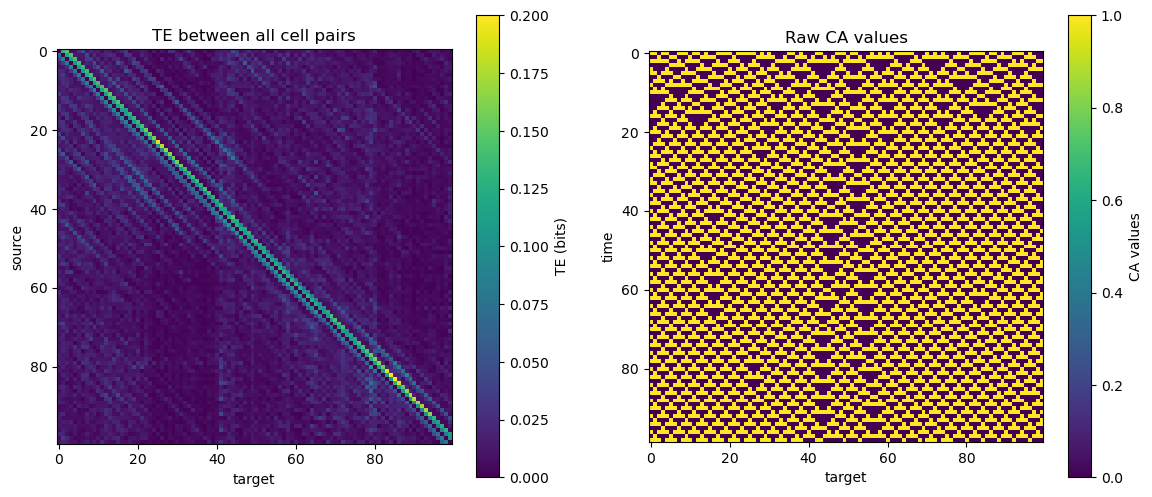

In [5]:
# Copy the MI analysis and plotting code cells into here; we will edit these to use TE

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
calc = calcClass(2, 4, 1, 1, 1, 1)
# 2. No other properties to set for discrete calculators.

results = numpy.zeros((networkSize,networkSize));
pValues = numpy.zeros((networkSize,networkSize));
# Compute for all pairs:
for d in range(networkSize):
    for s in range(networkSize):
        # For each source-dest pair:
        if (s == d):
            pValues[s,d] = 1;
            continue
        source = JArray(JInt, 1)(data[:, s].tolist())
        destination = JArray(JInt, 1)(data[:, d].tolist())

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.addObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()
        results[s,d] = result;
        
        # 6. Compute the (statistical significance via) null distribution analytically:
        measDist = calc.computeSignificance()
        pValues[s,d] = measDist.pValue;

# Plot the functional connectivity
plt.figure(figsize=(14,6))
plt.subplot(1,2,1) # left subplot
plt.imshow(results)
plt.xlabel('target');
plt.ylabel('source');
plt.title('TE between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('TE (bits)');
# Plot the first 100 time steps for the cells we're analysing:
plt.subplot(1,2,2) # right subplot
plt.imshow(data[:99,:networkSize]) # Plotting the first 100 time steps for first networkSize cells
plt.xlabel('target');
plt.ylabel('time');
plt.title('Raw CA values');
cbar = plt.colorbar()
cbar.set_label('CA values');

5. Run the script, and observe the results for the adjacency matrix for the TE directed functional network in the figure:
    * Compare the results to those for the MI functional network. Has the location of the strongest sources for each target changed? Is this what you expected? Is this beginning to inform us of a more sensible model of the dynamics for each target, given who we know the sources for each target are?
    * Do you still observe a modular block structure? How might we explain this with reference to the dynamics of the CA and the TE measure?
    * Could you select a reasonable threshold to select parent cells for each target cell here? Try replotting the TE results below but thresholding for parent selection via, e.g. `plt.imshow(results > 0.1);` for a threshold at 0.1 bits, to see if you can identify a threshold that works well everywhere.


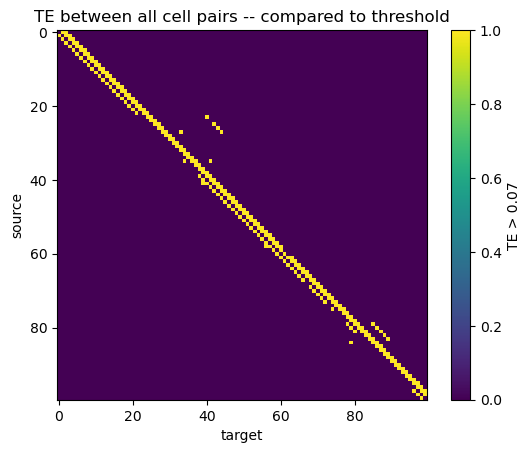

In [6]:
# Try replotting the TE results with a threshold for parent selection

threshold = 0.07
plt.figure()
plt.imshow(results > threshold)
plt.xlabel('target');
plt.ylabel('source');
plt.title('TE between all cell pairs -- compared to threshold');
cbar = plt.colorbar()
cbar.set_label('TE > %.2f' % threshold);

7. Let's look into making a more principled threshold selection based on computing the statistical significance of each TE calculation. We will add some code to the cell above to compute the p-values for the TE estimates from each source, analytically:
    * Go back to the AutoAnalyser, ticking the checkboxes for `Add stat. signif.?` and `analytically?` to generate some template code of how to do this. Press `Generate code` again.
    * Copy the calculation of the `measDist` object after the TE calculation (after comment `# 6. Compute ...`), paste it into the TE calculation code cell above, and then store its member value `measDist.pValue` into a 2D array `pValues` as we have already done for `results`. (Recall - what is the meaning of the p-value result for a given source?)
    * Where the if statement checks `if (s == d):` set `pValues[s,d] = 1;` before the `continue` statement otherwise seeing a 0 value there may confuse us.
8. Re-run the above TE calculations, and also run the following code cell to plot the p-values.<br/>
Take a look at the new figure below plotting the p-values. We will need to zoom in to see which sources have significant p-values here. We'll zoom in to only see sources which pass a Bonferroni corrected threshold `0.05 / (networkSize * (networkSize-1))` (to correct for the multiple comparisons here): uncomment the last line in the next code cell which now zooms in for us, and re-run this code cell.<br/>
Any p-value that is below the extreme maximal colour would pass a statistical test here and be inferred as a parent in the directed functional network.

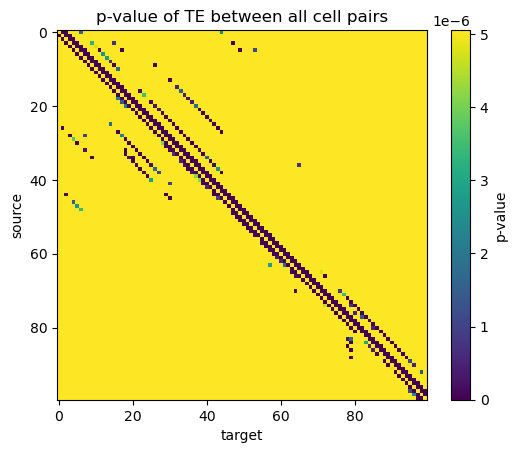

In [7]:
# Plot the p-values for each pairwise calculation:
plt.figure()
plt.imshow(pValues)
plt.xlabel('target');
plt.ylabel('source');
plt.title('p-value of TE between all cell pairs');
cbar = plt.colorbar()
cbar.set_label('p-value');
plt.clim(0,0.05/(networkSize*(networkSize-1))); # Can use this to highlight significant p-values

8. Compared to the MI functional network and thresholding the TE value, these directed functional networks capture the direct parents on either side of the target, and we've addressed the issue of a more principled threshold selection. Still:
    1. Are there many sources which appear to be parents here that you would not expect, given that we know only one source on either side of the target cell are its direct parents?
    2. Think about how we could extend the inference to exclude those other sources from being selected?

<hr/>

## C. Effective network inference with multivariate transfer entropy (mTE)

I've put together demonstration code to show a rudimentary implementation of the effective network inference on the CA data in the code cell below. This duplicates the more advanced [IDTxl](https://github.com/pwollstadt/IDTxl) toolkit in a simpler fashion.

1. Inspect the code, comparing it to the pairwise TE directed functional network code that we produced in the previous activity. Try to understand the main features:
    * Inside the loop over targets, where we infer the set of parents for each, we have an additional while loop over rounds of adding parents to the set.
    * Within each round, we have a loop over the candidate sources.
    * Each candidate source is evaluated using a conditional TE, conditioning on previously selected parents.
    * After all candidates are evaluated, we identify the candidate with the strongest conditional TE, and check the statistical significance of this value.
    * If the source is statistically significant, we continue to another round to try to select another parent. Else we stop for this target.
2. Try to run the code, and compare the results to your expectations for a good multivariate model explaining the dynamics of each cell, as well as to the functional networks from MI and pairwise TE above.
    * Think through why the inference method might still not completely match the underlying structure, including: parents for edge nodes being hidden, statistical fluctuations from the short data set effecting who the strongest sources are, and statistical power, hard coded history length used which may leave more information in spurious sources or remove it from genuine sources, no use of pruning step here, conservative p-value threshold and use of analytic surrogates.

Beginning greedy selection of parents for 0
Selected source 1, with TE(1->0 | )=0.27248, p-value=0.00000 (conditioning on 0 parents)
Selected source 2, with TE(2->0 | 1)=0.17113, p-value=0.00000 (conditioning on 1 parents)
Selected source 26, with TE(26->0 | 1,2)=0.06543, p-value=0.00000 (conditioning on 2 parents)
Selected source 46, with TE(46->0 | 1,2,26)=0.05114, p-value=0.00000 (conditioning on 3 parents)
-- Max TE source 7 was not significant (TE(7->0 | 1,2,26,46)=0.04778, p-value=0.003977), quitting
Beginning greedy selection of parents for 1
Selected source 0, with TE(0->1 | )=0.37738, p-value=0.00000 (conditioning on 0 parents)
Selected source 2, with TE(2->1 | 0)=0.50355, p-value=0.00000 (conditioning on 1 parents)
-- Max TE source 0 was not significant (TE(0->1 | 0,2)=0.00000, p-value=1.000000), quitting
Beginning greedy selection of parents for 2
Selected source 1, with TE(1->2 | )=0.27738, p-value=0.00000 (conditioning on 0 parents)
Selected source 3, with TE(3->2 | 1)=0.5

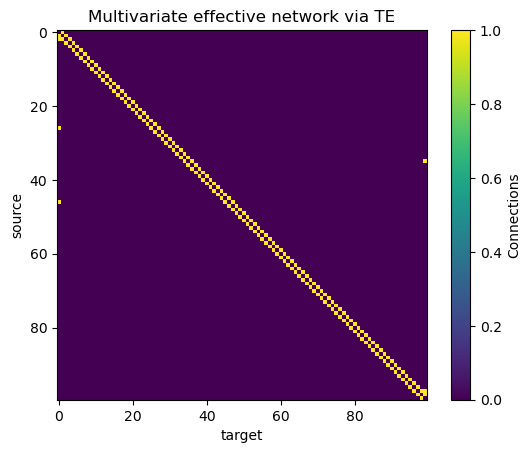

In [8]:
network = numpy.zeros((networkSize,networkSize), dtype=int);
# Compute for all targets:
for d in range(networkSize):

    print('Beginning greedy selection of parents for %d' % d);

    destination = JArray(JInt, 1)(data[:, d].tolist())
    conditionalSet = [];

    # Loop over rounds of parent selection:
    while (True):
        # Precondition: we have already selected the parents in
        #  conditionalSet, now we check if we can add to this:
        
        results = numpy.zeros((networkSize));
        pValues = numpy.zeros((networkSize));

        # 1. Construct the calculator:
        optimalK = 1; # For mTE inference, can be best to limit this to allow information to be found in sources
        if (len(conditionalSet) > 0):
            calcClass = JPackage("infodynamics.measures.discrete").ConditionalTransferEntropyCalculatorDiscrete
            calc = calcClass(2, optimalK, len(conditionalSet))
        else:
            calcClass = JPackage("infodynamics.measures.discrete").TransferEntropyCalculatorDiscrete
            calc = calcClass(2, optimalK, 1, 1, 1, 1)
        # 2. No other properties to set for discrete calculators.
        for s in range(networkSize):
            # For each source-dest pair:
            
            if ( (s == d) or (s in conditionalSet) ):
                # If s is the target, or already in the conditioning set, skip evaluating TE from it
                pValues[s] = 1;
                continue
            source = JArray(JInt, 1)(data[:, s].tolist())
            conditional = JArray(JInt, 2)(data[:, conditionalSet].tolist())

            # 3. Initialise the calculator for (re-)use:
            calc.initialise()
            # 4. Supply the sample data:
            if (len(conditionalSet) > 0):
                calc.addObservations(source, destination, conditional)
            else:
                calc.addObservations(source, destination)

            # 5. Compute the estimate:
            result = calc.computeAverageLocalOfObservations()
            # 6. Compute the (statistical significance via) null distribution analytically:
            measDist = calc.computeSignificance()

            results[s] = result;
            pValues[s] = measDist.pValue;

        # Check which was the strongest source:
        maxSourceIndex = numpy.argmax(results);
        maxTE = results[maxSourceIndex];
        if (pValues[maxSourceIndex] < 0.05/(networkSize*(networkSize-1))):
            print('Selected source %d, with TE(%d->%d | %s)=%.5f, p-value=%.5f (conditioning on %d parents)' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, \
                pValues[maxSourceIndex], len(conditionalSet) ));
            # Add this new source:
            conditionalSet.append(maxSourceIndex);
        else:
            print('-- Max TE source %d was not significant (TE(%d->%d | %s)=%.5f, p-value=%.6f), quitting' %\
                (maxSourceIndex, maxSourceIndex, d, (','.join(str(x) for x in conditionalSet)), maxTE, pValues[maxSourceIndex]));
            break
    
    # Postcondition: conditionalSet holds the parents for target d
    network[conditionalSet, d] = 1;

# Plot the effective connectivity network
plt.figure()
plt.imshow(network)
plt.xlabel('target');
plt.ylabel('source');
plt.title('Multivariate effective network via TE');
cbar = plt.colorbar()
cbar.set_label('Connections');

A sample results plot is shown in the solutions notebook (yours will not match precisely due to stochastic generation of the dynamics but should have similar features).

3. _Optional extensions -- advanced_:
    1. Notice that we used a `k` history of 1 for the TEs here. Think through what that change means, and why you might make different settings for it with TE versus effective network inference in some cases.
    2. Can you incorporate code to address any of those issues above to improve the network inference?

In [9]:
# Copy the code from the cell above and adapt it here

